# Decision Tree Regression
<hr>
<br>

**`Standart Devation`**

<Br>
$Std = \sqrt{\dfrac{\sum{ (x-myu)^2}} {n}}$
<br>
    <br>
$myu = \dfrac{\sum{x}}{n}$
<br>
<hr>
<br>
    
**`Standart Devation Reduction`**
<br>
<br>
$SDTR = STD(Label) - STD(Feature, Label)$
    

In [165]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np

In [166]:
data = pd.read_csv("Datasets/DTree.csv")
data

,Ob-Havo,Temp,Namlik,Shamol,Oyinchilar
0,Yomg'ir,Issiq,Yuqori,False,25
1,Yomg'ir,Issiq,Yuqori,True,30
2,Bulutli,Issiq,Yuqori,False,46
3,Quyoshli,Yaxshi,Yuqori,False,45
4,Quyoshli,Salqin,Normal,False,52
5,Quyoshli,Salqin,Normal,True,23
6,Bulutli,Salqin,Normal,True,43
7,Yomg'ir,Yaxshi,Yuqori,False,35
8,Yomg'ir,Salqin,Normal,False,38
9,Quyoshli,Yaxshi,Normal,False,46


In [167]:
def std(arr):
    myu = arr.mean()
    return np.sqrt(np.sum(np.square(arr - myu))/ len(arr))

In [168]:
std(data['Oyinchilar'].values)

9.321086474291743

In [158]:
def stdr(arr1,arr2):
    std_arr = std(arr2)
    uniq = np.unique(arr1)
    list_stdr = list()
    for i in uniq:
        label = arr2[arr1==i]
        print(i,":", std(label), "\t",len(label))
        list_stdr.append([len(label), std(label)])
    list_stdr = np.array(list_stdr).T
    
    return std_arr - np.dot(list_stdr[0]/len(arr[1]), list_stdr[1])
    


In [159]:
obhavo = stdr(data['Ob-Havo'].values, data['Oyinchilar'].values)
print("STDR(Ob-havo) : ", obhavo)

Bulutli : 3.491060010942235 	 4
Quyoshli : 10.870142593360953 	 5
Yomg'ir : 7.782030583337487 	 5
STDR(Ob-havo) :  1.6621503366302326


In [160]:
temp = stdr(data['Temp'].values, data['Oyinchilar'].values)
print("STDR(Temp) : ", temp)

Issiq : 8.954747344286158 	 4
Salqin : 10.51189802081432 	 4
Yaxshi : 7.6521601888326645 	 6
STDR(Temp) :  0.4796905747633211


In [161]:
namlik = stdr(data['Namlik'].values, data['Oyinchilar'].values)
print("STDR(Namlik) : ", namlik)

Normal : 8.734169352933014 	 7
Yuqori : 9.363411204670822 	 7
STDR(Namlik) :  0.272296195489826


In [162]:
shamol = stdr(data['Shamol'].values, data['Oyinchilar'].values)
print("STDR(Shamol) : ", temp)

False : 7.873015622999868 	 8
True : 10.593499054713803 	 6
STDR(Shamol) :  0.4796905747633211


In [45]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [41]:
dtree = DecisionTreeRegressor()

In [42]:
dtree.fit(feature, target)

DecisionTreeRegressor()

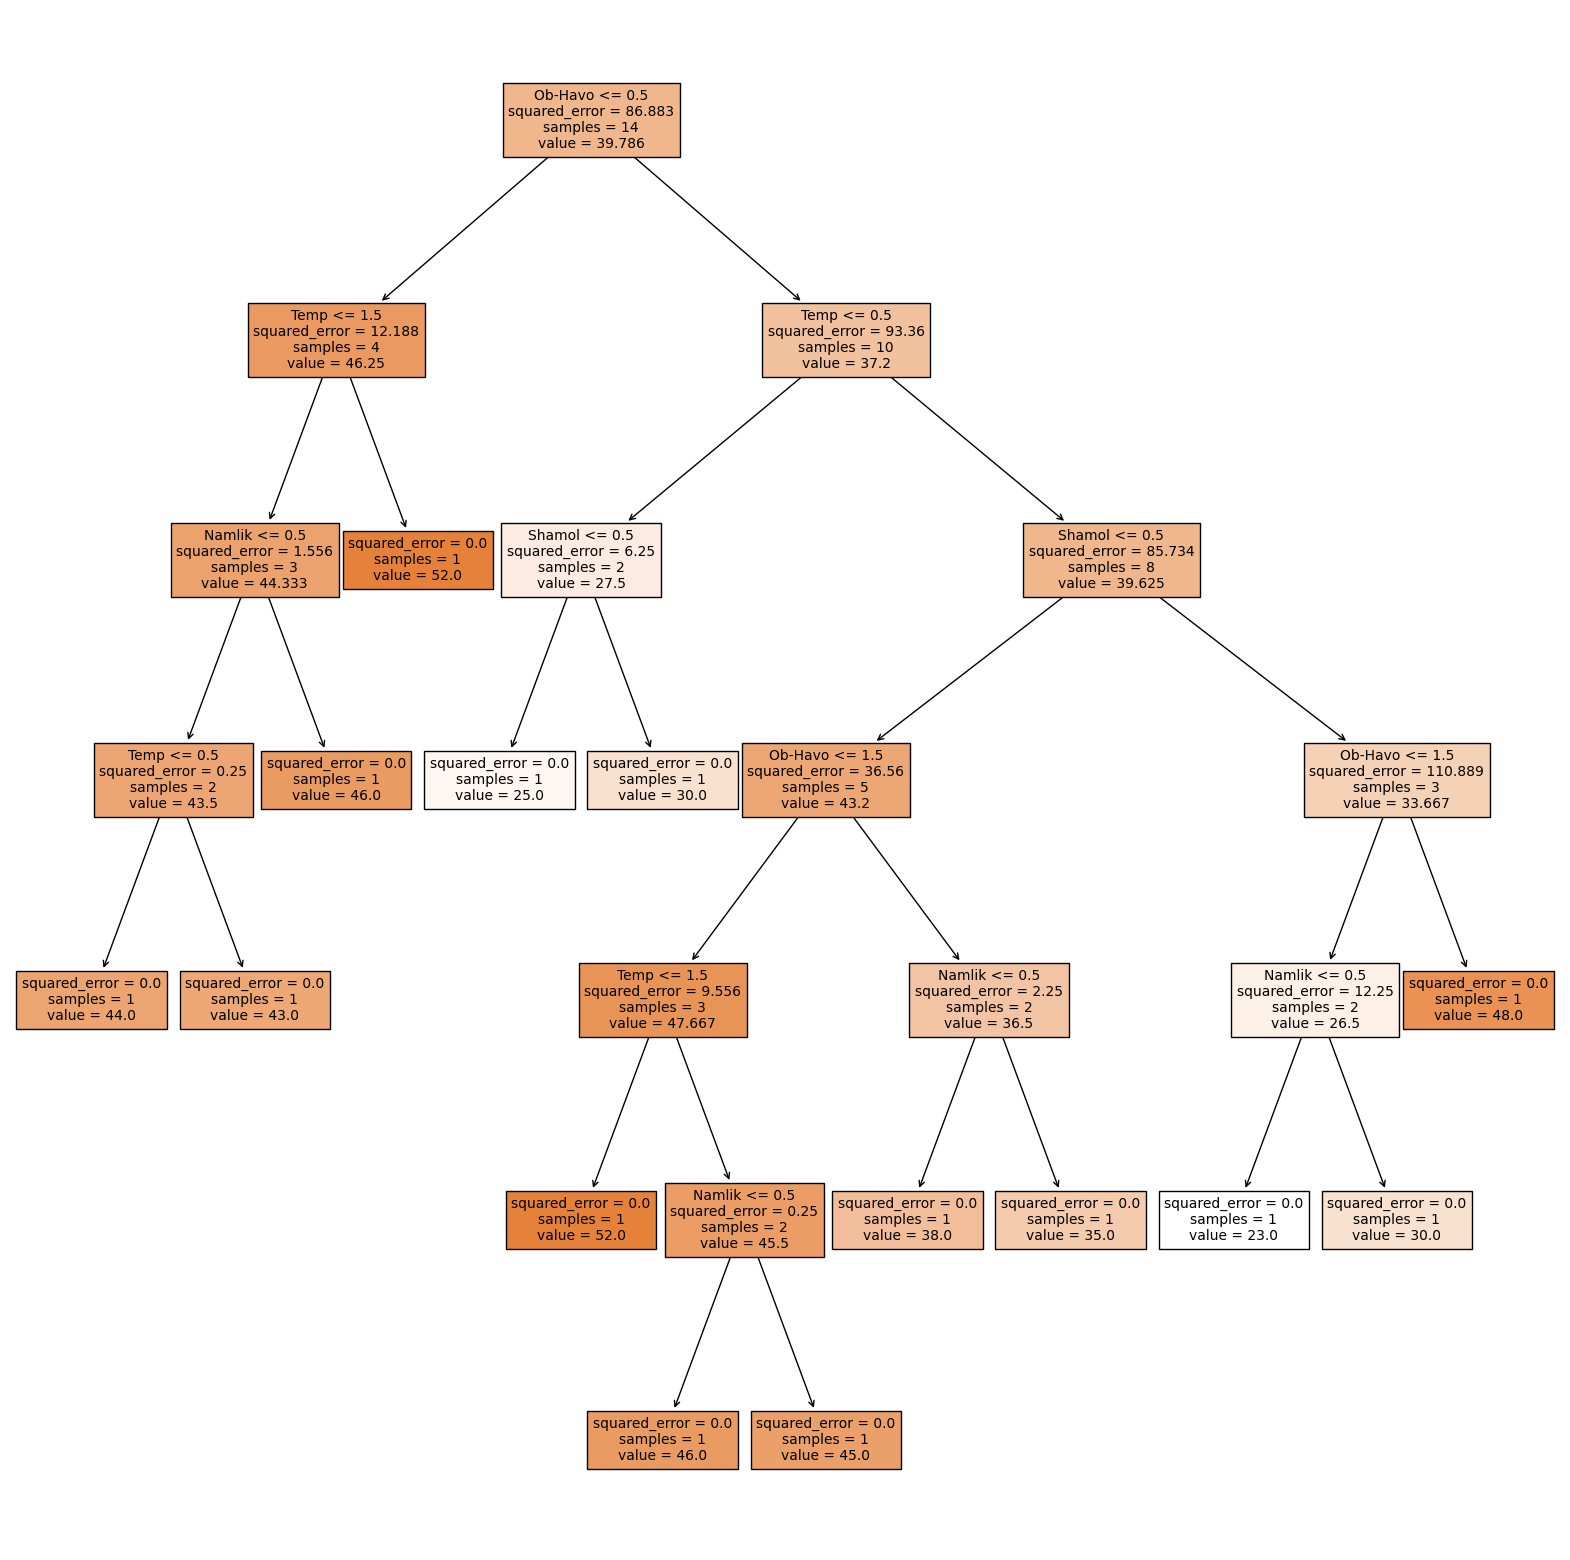

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plot_tree(dtree,filled=True,fontsize=10,feature_names=data.columns)
plt.show()

# Decision Tree Classification
<hr>
<br>

**`Entropy`**

$E(S) = \sum_{i=1}^n - p_i log_2 p_i$

<hr>
<br>

**`Information Gain`**
<br>
$Gain(S,A) = E(S) - \sum_{(v Values(A))}  \dfrac{S}{S_v} E(S_v)  $

In [163]:
data = pd.read_csv("Datasets/DTree.csv")
data
arr = np.array([1,1,1,1,1,0,1,0,0,1,1,0,0,0])
data['Oyinchilar'] = arr

In [87]:
def compute_impurity(feature, criteria="entropy"):
    """
    Supported impurity criteria: "entropy", "gini"
    """
    probs = np.unique(feature, return_counts=True)[1] 
    probs = probs / len(feature)
    
    if criteria=="entropy":
        return -1 * np.sum(np.log2(probs) * probs )
    
    elif criteria=="gini":
        
        return 1 - np.sum(np.square(probs))
    
    else:
        raise ValueError("Unkown criteria")

In [88]:
compute_impurity(arr)

0.9852281360342515

In [89]:
def information_gain(data, target,  split_criterion="entropy"):
    entropy_list = list()
    weight_list = list()
    target_entropy = compute_impurity(target, split_criterion)   
    for i in np.unique(data):
        
        label = target[data == i]
        
        
        entropy = compute_impurity(feature=label,  criteria=split_criterion)
        
        
        entropy_list.append( entropy )
        weight_list.append(len(label)/len(data))
   
    information_gain = target_entropy - np.sum(np.array(entropy_list) * weight_list)
    return information_gain
        

In [90]:
information_gain(data['Ob-Havo'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.0059777114237740125

In [91]:
information_gain(data['Temp'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.03914867190307081

In [92]:
information_gain(data['Namlik'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.0

In [93]:
information_gain(data['Shamol'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.011265848648557175

In [ ]:
class DecisionTreeNode()